In [1]:
# P.172 リスト5.1: 4,5,6,7/smiles_vae.py

import torch
from torch.nn.modules.module import DeviceLikeType
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm, notebook
from smiles_vae import SmilesVAE


def trainer(
    model: SmilesVAE,
    train_tensor: torch.Tensor,
    val_tensor: torch.Tensor,
    n_epoch: int = 10,
    lr: float = 1e-3,
    batch_size: int = 256,
    beta_schedule: list[float] = [0, 0, 0, 0, 0, 0.2, 0.4, 0.6, 0.8, 1.0],
    print_freq: int = 100,
    device: DeviceLikeType = "cpu",
) -> tuple[list[tuple[int, float]], list[tuple[int, float]], list[tuple[int, float]]]:
    """VAE の学習を行う関数

    Args:
        model (SmilesVAE): 学習する VAE モデル
        train_tensor (torch.Tensor): 訓練データの整数系列（サンプルサイズ * 最大系列長）
        val_tensor (torch.Tensor): 検証データの整数系列（サンプルサイズ * 最大系列長）
        n_epoch (int, optional): エポック数. Defaults to 10.
        lr (float, optional): 学習率. Defaults to 1e-3.
        batch_size (int, optional): ミニバッチを用いた確率的勾配降下法のバッチサイズ. Defaults to 256.
        beta_schedule (list[float], optional): KL 項の重みのスケジュール.
            Defaults to [0, 0, 0, 0, 0, 0.2, 0.4, 0.6, 0.8, 1.0].
        print_freq (int, optional): 途中経過を表示する頻度. Defaults to 100.
        device (DeviceLikeType, optional): 学習デバイス. Defaults to "cpu".

    Returns:
        tuple[list[tuple[int, float]], list[tuple[int, float]], list[tuple[int, float]]]:
            訓練データの損失関数の値、検証データの損失関数の値、検証データの再構成成功率
    """
    model.train()
    model.to(device)
    # 最適化手法のインスタンスを作成（モデルパラメタの最適化に確率的勾配降下法 (SGD) を用いる）
    # ここでは、確率的勾配降下法の中で Adaptive Moment Estimation を用いる
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # シャッフルありでバッチモードで訓練データの DataLoader を作成
    train_dataset = TensorDataset(torch.flip(train_tensor, dims=[1]), train_tensor)
    train_data_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )
    # シャッフルありでバッチモードで検証データの DataLoader を作成
    val_dataset = TensorDataset(torch.flip(val_tensor, dims=[1]), val_tensor)
    val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    # 訓練データの損失関数の値のリスト
    train_loss_list = []
    # 検証データの損失関数の値のリスト
    val_loss_list = []
    # 検証データの再構成成功率のリスト
    val_reconstruct_rate_list = []

    running_loss = 0
    running_sample_size = 0
    each_batch_idx = 0
    for each_epoch in notebook.tqdm(range(n_epoch)):
        try:
            model.beta = beta_schedule[each_epoch]
        except:
            pass
        tqdm.write(" beta = {}".format(model.beta))
        for each_train_batch in notebook.tqdm(train_data_loader, leave=False):
            # バッチごとに学習
            model.train()
            # 損失関数の計算
            each_loss = model.loss(
                each_train_batch[0].to(device), each_train_batch[1].to(device)
            )
            # 表示・作図用に記録
            running_loss += each_loss.item()
            running_sample_size += len(each_train_batch[0])
            # backward() 実行の度に optimizer に勾配が累積されるため、勾配を 0 にリセット
            optimizer.zero_grad()
            # パラメータに関する損失の勾配を計算
            each_loss.backward()
            # 蓄積した勾配を元にパラメタを更新
            optimizer.step()
            if (each_batch_idx + 1) % print_freq == 0:
                # print_freq の頻度で表示・作図用に記録
                train_loss_list.append(
                    (each_batch_idx + 1, running_loss / running_sample_size)
                )
                tqdm.write(
                    "#epoch: {}\t#update: {},\tper-example train loss:\t{}".format(
                        each_epoch,
                        each_batch_idx + 1,
                        running_loss / running_sample_size,
                    )
                )
            running_loss = 0
            running_sample_size = 0
            each_batch_idx += 1

        val_loss = 0
        each_val_success_list: list[bool] = []
        with torch.no_grad():
            # バッチごとに検証データの損失関数の値を計算（ここでは勾配の計算をしない）
            for each_val_batch in val_data_loader:
                # 損失関数の計算
                val_loss += model.loss(
                    each_val_batch[0].to(device), each_val_batch[1].to(device)
                ).item()
                each_val_success_list.extend(
                    model.reconstruct(each_val_batch[0].to(device), verbose=False)
                )
        val_loss_list.append((each_batch_idx + 1, val_loss / len(val_dataset)))
        val_reconstruct_rate_list.append(
            (
                each_batch_idx + 1,
                sum(each_val_success_list) / len(each_val_success_list),
            )
        )
        tqdm.write(
            "#update: {},\tper-example val loss:\t{}".format(
                each_batch_idx + 1, val_loss / len(val_dataset)
            )
        )
        tqdm.write(
            " * reconstruction success rate: {}".format(
                val_reconstruct_rate_list[-1][1]
            )
        )

    return train_loss_list, val_loss_list, val_reconstruct_rate_list

  0%|          | 0/10 [00:00<?, ?it/s]

 beta = 0.1


  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 0	#update: 100,	per-example train loss:	0.36845314502716064
#epoch: 0	#update: 200,	per-example train loss:	0.32897239923477173
#epoch: 0	#update: 300,	per-example train loss:	0.29312562942504883
#epoch: 0	#update: 400,	per-example train loss:	0.26114359498023987
#epoch: 0	#update: 500,	per-example train loss:	0.2402523308992386
#epoch: 0	#update: 600,	per-example train loss:	0.22862479090690613
#epoch: 0	#update: 700,	per-example train loss:	0.21667024493217468
#epoch: 0	#update: 800,	per-example train loss:	0.20778287947177887
#epoch: 0	#update: 900,	per-example train loss:	0.2060604691505432
#epoch: 0	#update: 1000,	per-example train loss:	0.2056899219751358
#epoch: 0	#update: 1100,	per-example train loss:	0.18875956535339355
#epoch: 0	#update: 1200,	per-example train loss:	0.19019804894924164
#epoch: 0	#update: 1300,	per-example train loss:	0.18508398532867432
#epoch: 0	#update: 1400,	per-example train loss:	0.1817820966243744
#epoch: 0	#update: 1500,	per-example train loss

  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 1	#update: 5000,	per-example train loss:	0.11074735969305038
#epoch: 1	#update: 5100,	per-example train loss:	0.11318362504243851
#epoch: 1	#update: 5200,	per-example train loss:	0.1163945198059082
#epoch: 1	#update: 5300,	per-example train loss:	0.11703014373779297
#epoch: 1	#update: 5400,	per-example train loss:	0.11486755311489105
#epoch: 1	#update: 5500,	per-example train loss:	0.11428618431091309
#epoch: 1	#update: 5600,	per-example train loss:	0.11076993495225906
#epoch: 1	#update: 5700,	per-example train loss:	0.11384649574756622
#epoch: 1	#update: 5800,	per-example train loss:	0.1066475510597229
#epoch: 1	#update: 5900,	per-example train loss:	0.10868579894304276
#epoch: 1	#update: 6000,	per-example train loss:	0.10742901265621185
#epoch: 1	#update: 6100,	per-example train loss:	0.1141236200928688
#epoch: 1	#update: 6200,	per-example train loss:	0.11089421063661575
#epoch: 1	#update: 6300,	per-example train loss:	0.11322520673274994
#epoch: 1	#update: 6400,	per-example 

  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 2	#update: 10000,	per-example train loss:	0.09482777863740921
#epoch: 2	#update: 10100,	per-example train loss:	0.09341159462928772
#epoch: 2	#update: 10200,	per-example train loss:	0.09317107498645782
#epoch: 2	#update: 10300,	per-example train loss:	0.09218642860651016
#epoch: 2	#update: 10400,	per-example train loss:	0.09012685716152191
#epoch: 2	#update: 10500,	per-example train loss:	0.08839165419340134
#epoch: 2	#update: 10600,	per-example train loss:	0.09091445803642273
#epoch: 2	#update: 10700,	per-example train loss:	0.08932751417160034
#epoch: 2	#update: 10800,	per-example train loss:	0.09289945662021637
#epoch: 2	#update: 10900,	per-example train loss:	0.0936051532626152
#epoch: 2	#update: 11000,	per-example train loss:	0.08668510615825653
#epoch: 2	#update: 11100,	per-example train loss:	0.08972971886396408
#epoch: 2	#update: 11200,	per-example train loss:	0.0868300125002861
#epoch: 2	#update: 11300,	per-example train loss:	0.08374675363302231
#epoch: 2	#update: 114

  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 3	#update: 15000,	per-example train loss:	0.08073583245277405
#epoch: 3	#update: 15100,	per-example train loss:	0.08828643709421158
#epoch: 3	#update: 15200,	per-example train loss:	0.07870744168758392
#epoch: 3	#update: 15300,	per-example train loss:	0.07840925455093384
#epoch: 3	#update: 15400,	per-example train loss:	0.07581228017807007
#epoch: 3	#update: 15500,	per-example train loss:	0.08447059988975525
#epoch: 3	#update: 15600,	per-example train loss:	0.07942185550928116
#epoch: 3	#update: 15700,	per-example train loss:	0.08202090114355087
#epoch: 3	#update: 15800,	per-example train loss:	0.07427753508090973
#epoch: 3	#update: 15900,	per-example train loss:	0.07832667231559753
#epoch: 3	#update: 16000,	per-example train loss:	0.07700424641370773
#epoch: 3	#update: 16100,	per-example train loss:	0.07605960220098495
#epoch: 3	#update: 16200,	per-example train loss:	0.07255605608224869
#epoch: 3	#update: 16300,	per-example train loss:	0.08009833097457886
#epoch: 3	#update: 1

  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 4	#update: 19900,	per-example train loss:	0.07512103766202927
#epoch: 4	#update: 20000,	per-example train loss:	0.07737172394990921
#epoch: 4	#update: 20100,	per-example train loss:	0.06928993761539459
#epoch: 4	#update: 20200,	per-example train loss:	0.06897526979446411
#epoch: 4	#update: 20300,	per-example train loss:	0.07393083721399307
#epoch: 4	#update: 20400,	per-example train loss:	0.07567281275987625
#epoch: 4	#update: 20500,	per-example train loss:	0.07227368652820587
#epoch: 4	#update: 20600,	per-example train loss:	0.07190808653831482
#epoch: 4	#update: 20700,	per-example train loss:	0.07112888246774673
#epoch: 4	#update: 20800,	per-example train loss:	0.07296068966388702
#epoch: 4	#update: 20900,	per-example train loss:	0.07517997175455093
#epoch: 4	#update: 21000,	per-example train loss:	0.0692582055926323
#epoch: 4	#update: 21100,	per-example train loss:	0.07262939214706421
#epoch: 4	#update: 21200,	per-example train loss:	0.06754960864782333
#epoch: 4	#update: 21

  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 5	#update: 24900,	per-example train loss:	0.07098466157913208
#epoch: 5	#update: 25000,	per-example train loss:	0.07360132783651352
#epoch: 5	#update: 25100,	per-example train loss:	0.06848686188459396
#epoch: 5	#update: 25200,	per-example train loss:	0.06751370429992676
#epoch: 5	#update: 25300,	per-example train loss:	0.06841262429952621
#epoch: 5	#update: 25400,	per-example train loss:	0.0713726356625557
#epoch: 5	#update: 25500,	per-example train loss:	0.0673813596367836
#epoch: 5	#update: 25600,	per-example train loss:	0.06841253489255905
#epoch: 5	#update: 25700,	per-example train loss:	0.0726340040564537
#epoch: 5	#update: 25800,	per-example train loss:	0.06585215777158737
#epoch: 5	#update: 25900,	per-example train loss:	0.07133086770772934
#epoch: 5	#update: 26000,	per-example train loss:	0.0715131163597107
#epoch: 5	#update: 26100,	per-example train loss:	0.06487811356782913
#epoch: 5	#update: 26200,	per-example train loss:	0.06916505843400955
#epoch: 5	#update: 26300

  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 6	#update: 29900,	per-example train loss:	0.06791811436414719
#epoch: 6	#update: 30000,	per-example train loss:	0.06519320607185364
#epoch: 6	#update: 30100,	per-example train loss:	0.0652346983551979
#epoch: 6	#update: 30200,	per-example train loss:	0.06359197944402695
#epoch: 6	#update: 30300,	per-example train loss:	0.06930611282587051
#epoch: 6	#update: 30400,	per-example train loss:	0.06662958115339279
#epoch: 6	#update: 30500,	per-example train loss:	0.06739719212055206
#epoch: 6	#update: 30600,	per-example train loss:	0.05839702486991882
#epoch: 6	#update: 30700,	per-example train loss:	0.06272735446691513
#epoch: 6	#update: 30800,	per-example train loss:	0.05905706062912941
#epoch: 6	#update: 30900,	per-example train loss:	0.06355784088373184
#epoch: 6	#update: 31000,	per-example train loss:	0.06667822599411011
#epoch: 6	#update: 31100,	per-example train loss:	0.05825728178024292
#epoch: 6	#update: 31200,	per-example train loss:	0.06531989574432373
#epoch: 6	#update: 31

  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 7	#update: 34900,	per-example train loss:	0.05766753479838371
#epoch: 7	#update: 35000,	per-example train loss:	0.05886222794651985
#epoch: 7	#update: 35100,	per-example train loss:	0.06201336905360222
#epoch: 7	#update: 35200,	per-example train loss:	0.06483924388885498
#epoch: 7	#update: 35300,	per-example train loss:	0.05927753075957298
#epoch: 7	#update: 35400,	per-example train loss:	0.06312886625528336
#epoch: 7	#update: 35500,	per-example train loss:	0.06267094612121582
#epoch: 7	#update: 35600,	per-example train loss:	0.06259150803089142
#epoch: 7	#update: 35700,	per-example train loss:	0.05972031131386757
#epoch: 7	#update: 35800,	per-example train loss:	0.05553821101784706
#epoch: 7	#update: 35900,	per-example train loss:	0.059676412492990494
#epoch: 7	#update: 36000,	per-example train loss:	0.05980316177010536
#epoch: 7	#update: 36100,	per-example train loss:	0.059154924005270004
#epoch: 7	#update: 36200,	per-example train loss:	0.059706911444664
#epoch: 7	#update: 3

  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 8	#update: 39800,	per-example train loss:	0.056298475712537766
#epoch: 8	#update: 39900,	per-example train loss:	0.05702907592058182
#epoch: 8	#update: 40000,	per-example train loss:	0.06274209916591644
#epoch: 8	#update: 40100,	per-example train loss:	0.0633721798658371
#epoch: 8	#update: 40200,	per-example train loss:	0.06471896171569824
#epoch: 8	#update: 40300,	per-example train loss:	0.05588284134864807
#epoch: 8	#update: 40400,	per-example train loss:	0.05960370600223541
#epoch: 8	#update: 40500,	per-example train loss:	0.05511661618947983
#epoch: 8	#update: 40600,	per-example train loss:	0.05161905288696289
#epoch: 8	#update: 40700,	per-example train loss:	0.058745063841342926
#epoch: 8	#update: 40800,	per-example train loss:	0.05641384422779083
#epoch: 8	#update: 40900,	per-example train loss:	0.05731750279664993
#epoch: 8	#update: 41000,	per-example train loss:	0.056935422122478485
#epoch: 8	#update: 41100,	per-example train loss:	0.05909140408039093
#epoch: 8	#update:

  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 9	#update: 44800,	per-example train loss:	0.053638581186532974
#epoch: 9	#update: 44900,	per-example train loss:	0.06169430911540985
#epoch: 9	#update: 45000,	per-example train loss:	0.05683407187461853
#epoch: 9	#update: 45100,	per-example train loss:	0.05884932354092598
#epoch: 9	#update: 45200,	per-example train loss:	0.05469382554292679
#epoch: 9	#update: 45300,	per-example train loss:	0.05557837337255478
#epoch: 9	#update: 45400,	per-example train loss:	0.05345974117517471
#epoch: 9	#update: 45500,	per-example train loss:	0.0606413334608078
#epoch: 9	#update: 45600,	per-example train loss:	0.05171974003314972
#epoch: 9	#update: 45700,	per-example train loss:	0.05148881673812866
#epoch: 9	#update: 45800,	per-example train loss:	0.05893246829509735
#epoch: 9	#update: 45900,	per-example train loss:	0.05395042151212692
#epoch: 9	#update: 46000,	per-example train loss:	0.05835943669080734
#epoch: 9	#update: 46100,	per-example train loss:	0.0556301474571228
#epoch: 9	#update: 46

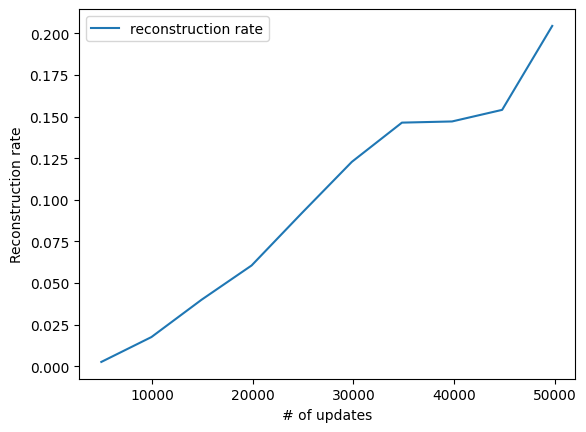

In [2]:
# P.178 リスト5.2: 4,5,6,7/smiles_vae_main.py

import matplotlib.pyplot as plt
import pickle
from smiles_vocab import SmilesVocabulary
from smiles_vae import SmilesVAE
from rdkit import Chem
from rdkit import RDLogger

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)


def valid_ratio(smiles_list: list[str]) -> float:
    """SMILES 文字列のリストから正しい SMILES 文字列の割合を計算

    Args:
        smiles_list (list[str]): SMILES 文字列のリスト

    Returns:
        float: 正しい SMILES 文字列の割合
    """
    n_success = 0
    for each_smiles in smiles_list:
        try:
            Chem.MolToSmiles(Chem.MolFromSmiles(each_smiles))
            n_success += 1
        except:
            pass
    return n_success / len(smiles_list)


if __name__ == "__main__":
    smiles_vocab = SmilesVocabulary()
    # 訓練データと検証データの整数系列を作成
    train_tensor = smiles_vocab.batch_update_from_file("train.smi")  # 1273104 * 102
    val_tensor = smiles_vocab.batch_update_from_file("val.smi")  # 79568 * 102
    max_len = val_tensor.shape[1]
    # VAE モデルのインスタンスを作成
    vae = SmilesVAE(
        smiles_vocab,
        latent_dim=64,
        emb_dim=256,
        encoder_params={
            "hidden_size": 512,
            "num_layers": 1,
            "bidirectional": False,
            "dropout": 0.0,
        },
        decoder_params={"hidden_size": 512, "num_layers": 1, "dropout": 0.0},
        encoder2out_params={"out_dim_list": [256]},
        max_len=max_len,
    )
    # 学習
    train_loss_list, val_loss_list, val_reconstruct_rate_list = trainer(
        vae,
        train_tensor,
        val_tensor,
        lr=1e-4,
        n_epoch=10,
        batch_size=256,
        beta_schedule=[0.1],
        print_freq=100,
        device="cuda",
    )
    # 学習中の訓練・検証用データセットにおける損失の値の推移をプロット
    plt.plot(*list(zip(*train_loss_list)), label="train loss")
    plt.plot(*list(zip(*val_loss_list)), label="validation loss", marker="*")
    plt.legend()
    plt.xlabel("# of updates")
    plt.ylabel("Loss function")
    plt.savefig("smiles_vae_learning_curve.pdf")
    plt.clf()
    # 学習中の検証用データセットにおける再構成成功率の値の推移をプロット
    plt.plot(*list(zip(*val_reconstruct_rate_list)), label="reconstruction rate")
    plt.legend()
    plt.xlabel("# of updates")
    plt.ylabel("Reconstruction rate")
    plt.savefig("reconstruction_rate_curve.pdf")
    
    # 1000 個の新規 SMILES 文字列を生成
    smiles_list = vae.generate(sample_size=1000, deterministic=True)
    print("success rate: {}".format(valid_ratio(smiles_list)))
    # 学習済みモデルのパラメータをファイルに保存
    torch.save(vae.state_dict(), "vae.pt")
    # 生成した SMILES 文字列をファイルに保存
    with open("vae_smiles.pkl", "wb") as f:
        pickle.dump(smiles_list, f)

In [3]:
import pickle

pickle.dump(smiles_vocab, open("5_smiles_vocab.pkl", "wb"))
pickle.dump(train_tensor, open("5_train_tensor.pkl", "wb"))
pickle.dump(val_tensor, open("5_val_tensor.pkl", "wb"))
pickle.dump(vae, open("5_vae.pkl", "wb"))
pickle.dump(train_loss_list, open("5_train_loss_list.pkl", "wb"))
pickle.dump(val_loss_list, open("5_val_loss_list.pkl", "wb"))
pickle.dump(val_reconstruct_rate_list, open("5_val_reconstruct_rate_list.pkl", "wb"))

# smiles_vocab: SmilesVocabulary = pickle.load(open("5_smiles_vocab.pkl", "rb"))
# train_tensor: torch.Tensor = pickle.load(open("5_train_tensor.pkl", "rb"))
# val_tensor: torch.Tensor = pickle.load(open("5_val_tensor.pkl", "rb"))
# vae: SmilesVAE = pickle.load(open("5_vae.pkl", "rb"))
# train_loss_list: list[tuple[int, float]] = pickle.load(
#     open("5_train_loss_list.pkl", "rb")
# )
# val_loss_list: list[tuple[int, float]] = pickle.load(open("5_val_loss_list.pkl", "rb"))
# val_reconstruct_rate_list: list[tuple[int, float]] = pickle.load(
#     open("5_val_reconstruct_rate_list.pkl", "rb")
# )